In [0]:
# 패키지 임포트
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# 데이터 세트 표준
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
# 데이터 세트 셰이프 확인
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


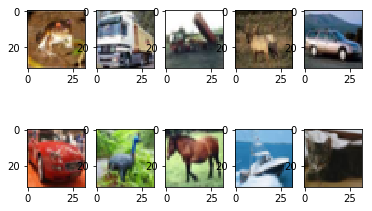

In [0]:
# 데이터 세트 이미지 확인
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i])
plt.show()

In [0]:
# 데이터 세트 라벨 확인
print(train_labels[0:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


In [0]:
# 데이터 세트 전처리
train_images = train_images
train_labels = to_categorical(train_labels)
test_images = test_images
test_labels = to_categorical(test_labels)

In [0]:
# 데이터 세트 전처리 후 셰이프 확인
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [0]:
# 컨볼루셔널 레이어 생성
def conv(filters, kernel_size, strides=1):
    return Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False,
        kernel_initializer='he_normal', kernel_regularizer=l2(0.0001))

In [0]:
# 레지듀얼 블록 A 생성
def first_residual_unit(filters, strides):
    def f(x):
        # →BN→ReLU
        x = BatchNormalization()(x)
        b = Activation('relu')(x)

        # 컨볼루셔널 레이어→BN→ReLU
        x = conv(filters // 4, 1, strides)(b)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 컨볼루셔널 레이어→BN→ReLU
        x = conv(filters // 4, 3)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # 컨볼루셔널 레이어→
        x = conv(filters, 1)(x)

        # 숏컷 셰이프 사이즈 조정
        sc = conv(filters, 1, strides)(b)

        # Add
        return Add()([x, sc])
    return f

In [0]:
# 레지듀얼 블록 B 생성
def residual_unit(filters):
    def f(x):
        sc = x
        
        # →BN→ReLU
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 컨볼루셔널 레이어→BN→ReLU
        x = conv(filters // 4, 1)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 컨볼루셔널 레이어→BN→ReLU
        x = conv(filters // 4, 3)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # 컨볼루셔널 레이어→
        x = conv(filters, 1)(x)

        # Add
        return Add()([x, sc])
    return f

In [0]:
# 레지듀얼 블록 A와 레지듀얼 블록 B x 17 생성
def residual_block(filters, strides, unit_size):
    def f(x):
        x = first_residual_unit(filters, strides)(x)
        for i in range(unit_size-1):
            x = residual_unit(filters)(x)
        return x
    return f

In [0]:
# 입력 데이터 셰이프
input = Input(shape=(32,32, 3))

# 컨볼루셔널 레이어
x = conv(16, 3)(input)

# 레지듀얼 블록 x 54
x = residual_block(64, 1, 18)(x)
x = residual_block(128, 2, 18)(x)
x = residual_block(256, 2, 18)(x)

# →BN→ReLU
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 풀링 레이어
x = GlobalAveragePooling2D()(x)

# 전결합 레이어
output = Dense(10, activation='softmax', kernel_regularizer=l2(0.0001))(x)

# 모델 생성
model = Model(inputs=input, outputs=output)

In [0]:
# 컴파일
model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['acc'])

In [0]:
# ImageDataGenerator 준비
train_gen  = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True,
    width_shift_range=0.125, 
    height_shift_range=0.125, 
    horizontal_flip=True)
test_gen = ImageDataGenerator(
    featurewise_center=True, 
    featurewise_std_normalization=True)

# 데이터 세트 전체 총합량을 미리 계산
for data in (train_gen, test_gen):
    data.fit(train_images)

In [0]:
# LearningRateScheduler 준비
def step_decay(epoch):
    x = 0.1
    if epoch >= 80: x = 0.01
    if epoch >= 120: x = 0.001
    return x
lr_decay = LearningRateScheduler(step_decay)

In [0]:
# 학습
batch_size = 128
history = model.fit_generator(
    train_gen.flow(train_images, train_labels, batch_size=batch_size),
    epochs=100,
    steps_per_epoch=train_images.shape[0] // batch_size,
    validation_data=test_gen.flow(test_images, test_labels, batch_size=batch_size),
    validation_steps=test_images.shape[0] // batch_size,
    callbacks=[lr_decay])

In [0]:
# 모델 저장
model.save('resnet.h5')

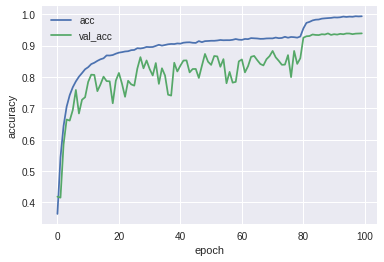

In [0]:
# 그래프 표시
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [0]:
# 평가
batch_size = 128
test_loss, test_acc = model.evaluate_generator(
    test_gen.flow(test_images, test_labels, batch_size=batch_size),
    steps=10)
print('loss: {:.3f}\nacc: {:.3f}'.format(test_loss, test_acc ))

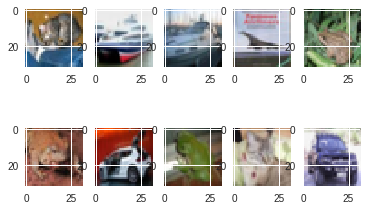

['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile']


In [0]:
# 추론할 이미지 표시
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i])
plt.show()

# 추론한 라벨 표시
test_predictions = model.predict_generator(
    test_gen.flow(test_images[0:10], shuffle = False, batch_size=1),
    steps=10)
test_predictions = np.argmax(test_predictions, axis=1)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
        'dog', 'frog', 'horse', 'ship', 'truck']
print([labels[n] for n in test_predictions])